In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/series temporales/df_diccs_parametros_uniqW.csv')

In [ ]:
df = df[['id', 'dialog_id', 'uniqWeight', 'sender_class']]

In [ ]:
df.head()

,id,dialog_id,uniqWeight,sender_class
0,0,0xab38710,0.179995,Bot
1,1,0xab38710,0.183899,Human
2,2,0xab38710,0.107382,Bot
3,3,0xab38710,0.109968,Human
4,4,0xab38710,0.152454,Bot


In [ ]:
len(df)

47234

In [ ]:
series = [serie for _, serie in df.groupby(by=['dialog_id', 'sender_class'])]

In [ ]:
len(series)

5551

Nos quedamos con series de al menos 4 interacciones y maximo 30
y que no tengan valores de uniqWeight por fuera del rango (0,1)

In [ ]:
min_lenght = 4
max_lenght = 30

series_to_drop = []

for i in range(len(series)):
  if len(series[i]) < min_lenght or len(series[i]) > max_lenght:
    series_to_drop.append(i)
  if (series[i]['uniqWeight'] > 1).any() or (series[i]['uniqWeight'] < 0).any():
    series_to_drop.append(i)
for ele in sorted(series_to_drop, reverse = True):
    del series[ele]

In [ ]:
len(series)

2709

In [ ]:
longitudes = []
for serie in series:
  longitudes.append(len(serie))

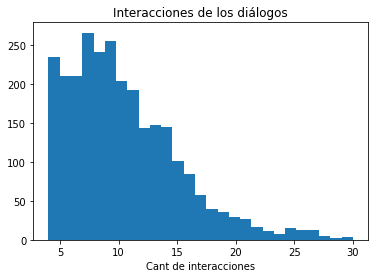

In [ ]:
plt.hist(longitudes, bins=27)
plt.xlabel('Cant de interacciones')
plt.title('Interacciones de los diálogos')
plt.show()

In [ ]:
np.mean(longitudes)

10.204872646733111

In [ ]:
series[0]

,id,dialog_id,uniqWeight,sender_class
4153,1,0x1017098c,0.331417,Bot
4155,3,0x1017098c,0.310380,Bot
4157,5,0x1017098c,0.305118,Bot
4159,7,0x1017098c,0.378276,Bot
4161,9,0x1017098c,0.366690,Bot
4163,11,0x1017098c,0.379218,Bot
4165,13,0x1017098c,0.364733,Bot
4167,15,0x1017098c,0.350182,Bot
4169,17,0x1017098c,0.350182,Bot
4171,19,0x1017098c,0.373258,Bot


Atencion: la clase "bot" es la clase 1. 
La clase 'human' es la clase 0.

In [ ]:
X = []
y = []
for i, serie in enumerate(series):
  X.append(serie['uniqWeight'])
  y.append(int(serie['sender_class'].iloc[0] == 'Bot'))

y = np.array(y)

In [ ]:
random_state = 1

X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size=0.2, random_state=random_state)
print('Train X: '+str(len(X_train)))
print('Train y: '+str(len(y_train)))
print('Dev X: '+str(len(X_dev)))
print('Dev y: '+str(len(y_dev)))
print('Test X: '+str(len(X_test)))
print('Test y: '+str(len(y_test)))

Train X: 1733
Train y: 1733
Dev X: 434
Dev y: 434
Test X: 542
Test y: 542


Vamos a usar DTW (Dynamic Time Warping) para comparar las series temporales
Que es esto?: https://towardsdatascience.com/dynamic-time-warping-3933f25fcdd

In [ ]:
###  OJO!! Cada instancia de test tarda unos 5 segundos en predecir. 

cuantas_instancias_de_test_corremos = 1


cuantas_instancias_de_test_corremos = min(cuantas_instancias_de_test_corremos, len(X_test))
predicciones = np.zeros(cuantas_instancias_de_test_corremos)

for i in range(len(predicciones)):

  distancia_acumualda = np.zeros(2)

  min_dist = 1
  min_dist_el = 0

  max_dist = 0
  max_dist_el = 0

  for j in range(len(X_train)):
    dist = fastdtw(X_train[j], X_test[i], dist=euclidean)[0]
    distancia_acumualda[y_train[j]] += dist

    if dist < min_dist:
      min_dist = dist
      min_dist_el = j

    if dist > max_dist:
      max_dist = dist
      max_dist_el = j

  distancia_acumualda[0] /= len(y_train[y_train==0])
  distancia_acumualda[1] /= len(y_train[y_train==1])

  if distancia_acumualda[1] < distancia_acumualda[0]:
    predicciones[i] = 1


In [ ]:
print(min_dist)
print(min_dist_el)

0.27709810213145714
1230


In [ ]:
print(max_dist)
print(max_dist_el)

6.155192175986583
989


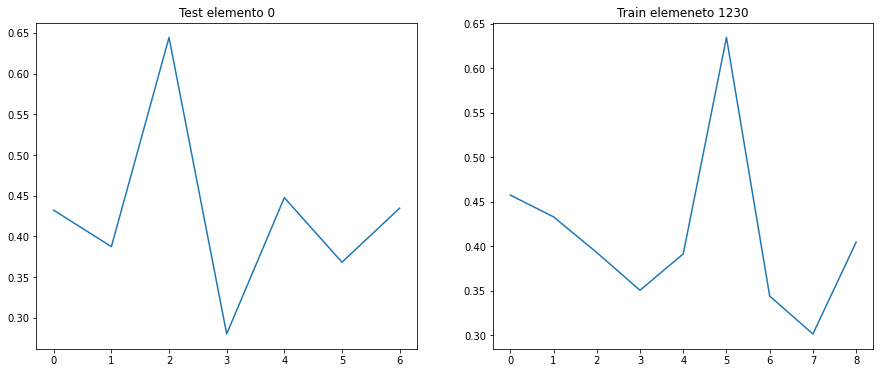

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(15,6))

axs[0].set_title('Test elemento 0')
axs[1].set_title('Train elemeneto 1230')

axs[0].plot(np.array(X_test[0]))
axs[1].plot(np.array(X_train[1230]))
#plt.title('Elemento de train set con minima distancia DTW al elemento a predecir de Test set: 0.277')
plt.show()

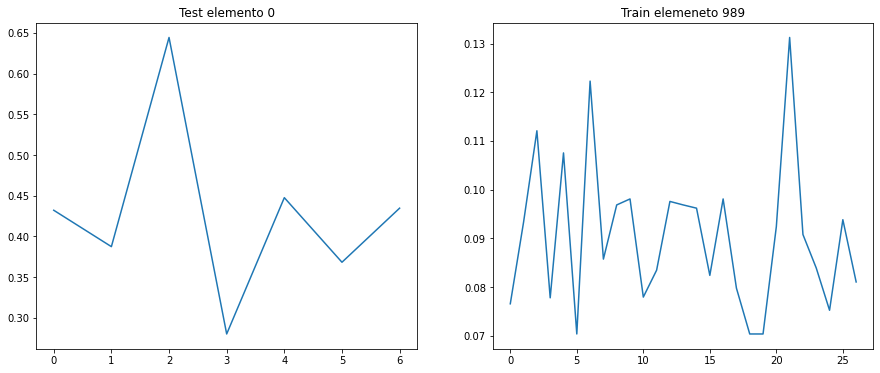

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(15,6))

axs[0].set_title('Test elemento 0')
axs[1].set_title('Train elemeneto 989')

axs[0].plot(np.array(X_test[0]))
axs[1].plot(np.array(X_train[989]))
#plt.title('Elemento de train set con minima distancia DTW al elemento a predecir de Test set: 0.277')
plt.show()

Comparemos el ground truth con lo predicho. En el caso de muestras generadas al azar, deberia dar cerca de 0.5 (si corremos unos cuantos ejemplos de test)

In [ ]:
predicciones_correctas = np.sum(y_test[:cuantas_instancias_de_test_corremos] == predicciones)

predicciones_correctas_pretty_print = round(100 * predicciones_correctas / cuantas_instancias_de_test_corremos, 3)
print("Predicciones correctas: {} %".format(str(predicciones_correctas_pretty_print)))

Predicciones correctas: 59.041 %


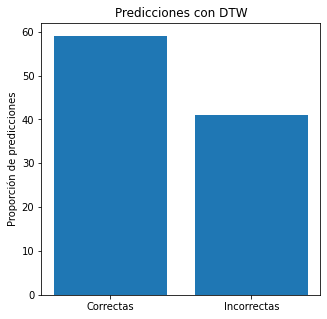

In [ ]:
 
fig = plt.figure(figsize = (5, 5))
 
# creating the bar plot
#plt.bar(['Correctas', 'Incorrectas'], x=[0,1],[predicciones_correctas_pretty_print, 100-predicciones_correctas_pretty_print], width = 0.5)
 
plt.bar([0,1], [predicciones_correctas_pretty_print, 100-predicciones_correctas_pretty_print])
plt.xticks([0,1], ['Correctas', 'Incorrectas'])
plt.ylabel("Proporción de predicciones")
plt.title("Predicciones con DTW")
plt.show()

Probemos otro approach: k-nearest neighbours
Lo que hacemos aca es correr el algoritmo con varios valores de k, desde 1 hasta k_max que fijamos justo aca abajo. 
Comparamos cada instancia de "dev" con todas las instancias de train para sacar su distancia DTW y armamos un listado con las k instancias de train que mas cerca estan de la instancia "dev". Luego nos fijamos a que categoria (1 o 0) pertenece la mayoria de sus k vecinos mas cercanos y esa es la etiqueta que predecimos para dicha instancia "dev".
Una vez que encontramos el valor de k que maximiza accuracy, corremos el subset de "test" con ese valor de k. Ahi sacamos el accuracy a presentar.

In [ ]:
k_max = 25
cuantas_instancias_de_test_corremos = len(X_dev) #es decir, todas. Para probar reducir a 5 o 10


predicciones_summary = []
predicciones_summary_k = []


for k in range(1, k_max+1, 2):
  predicciones_summary_k.append(k)
  cuantas_instancias_de_test_corremos = min(cuantas_instancias_de_test_corremos, len(X_dev))
  predicciones = np.zeros(cuantas_instancias_de_test_corremos, dtype=np.int32)

  for i in range(len(predicciones)):

    closest_neighbours = np.zeros(k, dtype=np.int32)
    closest_distance = np.ones(k)

    for j in range(len(X_train)):
      distancia = fastdtw(X_train[j], X_dev[i], dist=euclidean)[0]
      if distancia < np.amax(closest_distance):
        index = np.argmax(closest_distance)
        closest_neighbours[index] = j
        closest_distance[index] = distancia

    if np.sum(y_train[closest_neighbours]) > k/2:
      predicciones[i] = 1

  predicciones_correctas = np.sum(y_test[:cuantas_instancias_de_test_corremos] == predicciones)

  predicciones_correctas_pretty_print = round(100 * predicciones_correctas / cuantas_instancias_de_test_corremos, 3)
  predicciones_summary.append(predicciones_correctas_pretty_print)
  print("Predicciones correctas con k={}: {} %".format(str(k), str(predicciones_correctas_pretty_print)))

Predicciones correctas con k=1: 53.917 %
Predicciones correctas con k=3: 53.917 %
Predicciones correctas con k=5: 53.226 %
Predicciones correctas con k=7: 52.995 %
Predicciones correctas con k=9: 52.535 %
Predicciones correctas con k=11: 53.687 %
Predicciones correctas con k=13: 54.608 %
Predicciones correctas con k=15: 55.069 %
Predicciones correctas con k=17: 55.76 %
Predicciones correctas con k=19: 55.53 %
Predicciones correctas con k=21: 54.147 %
Predicciones correctas con k=23: 54.608 %
Predicciones correctas con k=25: 53.226 %


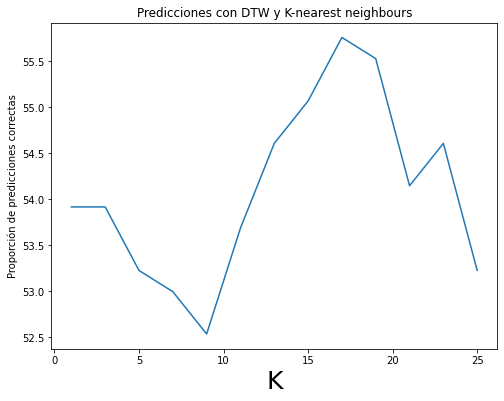

In [ ]:
fig = plt.figure(figsize = (8, 6))

plt.plot(predicciones_summary_k, predicciones_summary)
plt.xlabel("K", fontsize=25)
plt.ylabel("Proporción de predicciones correctas")
plt.title("Predicciones con DTW y K-nearest neighbours")
plt.show()

## Probemos con LSTM

In [ ]:
series_de_10 = []
for s in series:
  if len(s) == 10:
    series_de_10.append(s)

In [ ]:
len(series_de_10)

204

In [ ]:
series_de_10[0]

,id,dialog_id,uniqWeight,sender_class
23004,0,0x116dfe01,0.390083,Bot
23006,2,0x116dfe01,0.198741,Bot
23008,4,0x116dfe01,0.378308,Bot
23010,6,0x116dfe01,0.378340,Bot
23012,8,0x116dfe01,0.392206,Bot
23014,10,0x116dfe01,0.366115,Bot
23016,12,0x116dfe01,0.260378,Bot
23018,14,0x116dfe01,0.289445,Bot
23020,16,0x116dfe01,0.282057,Bot
23022,18,0x116dfe01,0.198823,Bot


In [ ]:
X = []
y = []
for s in series_de_10:
  X.append(np.array(s.uniqWeight))
  y.append(int(s.sender_class.iloc[0]=='Bot'))

X = np.array(X)
y = np.array(y)

In [ ]:
X.shape

(204, 10)

In [ ]:
y.shape

(204,)

In [ ]:
random_state = 1

X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size=0.2, random_state=random_state)
print('Train X: '+str(len(X_train)))
print('Train y: '+str(len(y_train)))
print('Dev X: '+str(len(X_dev)))
print('Dev y: '+str(len(y_dev)))
print('Test X: '+str(len(X_test)))
print('Test y: '+str(len(y_test)))

Train X: 130
Train y: 130
Dev X: 33
Dev y: 33
Test X: 41
Test y: 41


In [101]:
import tensorflow as tf

input_seq = tf.keras.Input(shape=(X_train.shape[1],1), name="seq")

x = tf.keras.layers.LSTM(64, return_sequences=True)(input_seq)
x = tf.keras.layers.LSTM(32, return_sequences=False)(x)

x = tf.keras.layers.Dropout(rate=0.5)(x)

x = tf.keras.layers.Dense(256, activation="relu")(x)

x = tf.keras.layers.Dropout(rate=0.5)(x) 

output = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)

model = tf.keras.Model(input_seq, output)

model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seq (InputLayer)             [(None, 10, 1)]           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 10, 64)            16896     
_________________________________________________________________
lstm_23 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 257 

In [102]:
batch_size  = 256
lr          = 1e-2
epochs      = 1500

In [103]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics='accuracy')

In [104]:
fiteo = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_dev, y_dev), validation_batch_size=batch_size)

Epoch 1/1500
1/1 [==============================] - 4s 4s/step - loss: 0.6941 - accuracy: 0.4385 - val_loss: 0.6944 - val_accuracy: 0.4848
Epoch 2/1500
1/1 [==============================] - 0s 49ms/step - loss: 0.6903 - accuracy: 0.5692 - val_loss: 0.6999 - val_accuracy: 0.4848
Epoch 3/1500
1/1 [==============================] - 0s 45ms/step - loss: 0.6872 - accuracy: 0.5769 - val_loss: 0.7127 - val_accuracy: 0.4848
Epoch 4/1500
1/1 [==============================] - 0s 41ms/step - loss: 0.6926 - accuracy: 0.5692 - val_loss: 0.7127 - val_accuracy: 0.4848
Epoch 5/1500
1/1 [==============================] - 0s 46ms/step - loss: 0.6772 - accuracy: 0.5769 - val_loss: 0.7038 - val_accuracy: 0.4848
Epoch 6/1500
1/1 [==============================] - 0s 46ms/step - loss: 0.6865 - accuracy: 0.5615 - val_loss: 0.6919 - val_accuracy: 0.4545
Epoch 7/1500
1/1 [==============================] - 0s 46ms/step - loss: 0.6736 - accuracy: 0.5769 - val_loss: 0.6817 - val_accuracy: 0.5758
Epoch 8/1500
1/

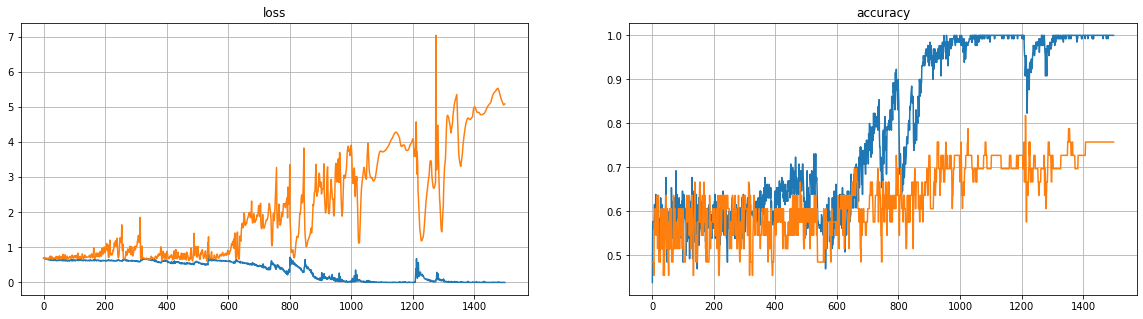

In [105]:
history = fiteo.history
zoom_factor = 1

total_epochs   = int(len(history['loss']))
start_at_epoch = total_epochs - int(total_epochs / zoom_factor)
f, axarr       = plt.subplots(1,2, figsize=(20,5))

axarr[0].plot(range(start_at_epoch, total_epochs), history['loss'][start_at_epoch:])
axarr[0].plot(range(start_at_epoch, total_epochs), history['val_loss'][start_at_epoch:])
axarr[0].set_title('loss')
axarr[0].grid()

axarr[1].plot(range(start_at_epoch, total_epochs), history['accuracy'][start_at_epoch:])
axarr[1].plot(range(start_at_epoch, total_epochs), history['val_accuracy'][start_at_epoch:])
axarr[1].set_title('accuracy')
axarr[1].grid()


## Veamos como da en el Test set

In [106]:
model.evaluate(x=X_test, y=y_test)

2/2 [==============================] - 0s 7ms/step - loss: 5.1578 - accuracy: 0.7561


[5.157809734344482, 0.7560975551605225]

# Nada mal!! un 75% de accuracy. 
# To do: probar con todo el dataset interpolado